This notebook is the copy of Flow Matching notebook. In this we will try to use Optimal Transport.

In [186]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
from tqdm.notebook import tqdm

from src.model. models import DBModel
from src.data.helpers import get_moons_dataset, rotate, get_accuracy
from src.visualization.visualize import plot_decision_boundary

from functools import partial
import warnings
from typing import Optional, Union
import ot as pot

In [187]:
import pandas as pd

class ModelParamsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, angle_change: int = 45):
        self.dataset_path = dataset_path
        self.dataset = pd.read_csv(dataset_path)
        # self.dataset = self.dataset.groupby("angle")
        self.angle_change = angle_change
        self.weights = self.dataset.drop(columns=["model_name", "angle"]).astype('float32')
        self.angles = self.dataset["angle"]
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        weights = torch.tensor(self.weights.iloc[idx].values)
        angle = torch.tensor(self.angles.iloc[idx], dtype=torch.int64)

        return weights, angle

In [188]:
class Flow(nn.Module):
    def __init__(self, hidden_dim=128):
        super(Flow, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(36, hidden_dim),
            nn.SELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.Linear(hidden_dim, 33)
        )
    
    def forward(self, x):
        return self.layers(x)

In [189]:
def compute_conditional_vector_field(x0, x1):
    return x1 - x0


def sample_conditional_pt(x0, x1, t, sigma):
    t = t.reshape(-1, *([1] * (x0.dim() - 1)))
    mu_t = t * x1 + (1 - t) * x0
    epsilon = torch.randn_like(x0)
    return mu_t + sigma * epsilon

In [190]:
class OTPlanSampler:
    """OTPlanSampler implements sampling coordinates according to an OT plan (wrt squared Euclidean
    cost) with different implementations of the plan calculation."""

    def __init__(
        self,
        method: str,
        reg: float = 0.05,
        reg_m: float = 1.0,
        normalize_cost: bool = False,
        num_threads: Union[int, str] = 1,
        warn: bool = True,
    ) -> None:
        """Initialize the OTPlanSampler class.

        Parameters
        ----------
        method: str
            choose which optimal transport solver you would like to use.
            Currently supported are ["exact", "sinkhorn", "unbalanced",
            "partial"] OT solvers.
        reg: float, optional
            regularization parameter to use for Sinkhorn-based iterative solvers.
        reg_m: float, optional
            regularization weight for unbalanced Sinkhorn-knopp solver.
        normalize_cost: bool, optional
            normalizes the cost matrix so that the maximum cost is 1. Helps
            stabilize Sinkhorn-based solvers. Should not be used in the vast
            majority of cases.
        num_threads: int or str, optional
            number of threads to use for the "exact" OT solver. If "max", uses
            the maximum number of threads.
        warn: bool, optional
            if True, raises a warning if the algorithm does not converge
        """
        # ot_fn should take (a, b, M) as arguments where a, b are marginals and
        # M is a cost matrix
        if method == "exact":
            self.ot_fn = partial(pot.emd, numThreads=num_threads)
        elif method == "sinkhorn":
            self.ot_fn = partial(pot.sinkhorn, reg=reg)
        elif method == "unbalanced":
            self.ot_fn = partial(pot.unbalanced.sinkhorn_knopp_unbalanced, reg=reg, reg_m=reg_m)
        elif method == "partial":
            self.ot_fn = partial(pot.partial.entropic_partial_wasserstein, reg=reg)
        else:
            raise ValueError(f"Unknown method: {method}")
        self.reg = reg
        self.reg_m = reg_m
        self.normalize_cost = normalize_cost
        self.warn = warn

    def get_map(self, x0, x1):
        """Compute the OT plan (wrt squared Euclidean cost) between a source and a target
        minibatch.

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the source minibatch

        Returns
        -------
        p : numpy array, shape (bs, bs)
            represents the OT plan between minibatches
        """
        a, b = pot.unif(x0.shape[0]), pot.unif(x1.shape[0])
        if x0.dim() > 2:
            x0 = x0.reshape(x0.shape[0], -1)
        if x1.dim() > 2:
            x1 = x1.reshape(x1.shape[0], -1)
        M = torch.cdist(x0, x1) ** 2
        if self.normalize_cost:
            M = M / M.max()  # should not be normalized when using minibatches
        p = self.ot_fn(a, b, M.detach().cpu().numpy())
        if not np.all(np.isfinite(p)):
            print("ERROR: p is not finite")
            print(p)
            print("Cost mean, max", M.mean(), M.max())
            print(x0, x1)
        if np.abs(p.sum()) < 1e-8:
            if self.warn:
                warnings.warn("Numerical errors in OT plan, reverting to uniform plan.")
            p = np.ones_like(p) / p.size
        return p

    def sample_map(self, pi, batch_size, replace=True):
        r"""Draw source and target samples from pi  $(x,z) \sim \pi$

        Parameters
        ----------
        pi : numpy array, shape (bs, bs)
            represents the source minibatch
        batch_size : int
            represents the OT plan between minibatches
        replace : bool
            represents sampling or without replacement from the OT plan

        Returns
        -------
        (i_s, i_j) : tuple of numpy arrays, shape (bs, bs)
            represents the indices of source and target data samples from $\pi$
        """
        p = pi.flatten()
        p = p / p.sum()
        choices = np.random.choice(
            pi.shape[0] * pi.shape[1], p=p, size=batch_size, replace=replace
        )
        return np.divmod(choices, pi.shape[1])

    def sample_plan(self, x0, x1, replace=True):
        r"""Compute the OT plan $\pi$ (wrt squared Euclidean cost) between a source and a target
        minibatch and draw source and target samples from pi $(x,z) \sim \pi$

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the source minibatch
        replace : bool
            represents sampling or without replacement from the OT plan

        Returns
        -------
        x0[i] : Tensor, shape (bs, *dim)
            represents the source minibatch drawn from $\pi$
        x1[j] : Tensor, shape (bs, *dim)
            represents the source minibatch drawn from $\pi$
        """
        pi = self.get_map(x0, x1)
        i, j = self.sample_map(pi, x0.shape[0], replace=replace)
        return x0[i], x1[j], j

    def sample_plan_with_labels(self, x0, x1, y0=None, y1=None, replace=True):
        r"""Compute the OT plan $\pi$ (wrt squared Euclidean cost) between a source and a target
        minibatch and draw source and target labeled samples from pi $(x,z) \sim \pi$

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        y0 : Tensor, shape (bs)
            represents the source label minibatch
        y1 : Tensor, shape (bs)
            represents the target label minibatch
        replace : bool
            represents sampling or without replacement from the OT plan

        Returns
        -------
        x0[i] : Tensor, shape (bs, *dim)
            represents the source minibatch drawn from $\pi$
        x1[j] : Tensor, shape (bs, *dim)
            represents the target minibatch drawn from $\pi$
        y0[i] : Tensor, shape (bs, *dim)
            represents the source label minibatch drawn from $\pi$
        y1[j] : Tensor, shape (bs, *dim)
            represents the target label minibatch drawn from $\pi$
        """
        pi = self.get_map(x0, x1)
        i, j = self.sample_map(pi, x0.shape[0], replace=replace)
        return (
            x0[i],
            x1[j],
            y0[i] if y0 is not None else None,
            y1[j] if y1 is not None else None,
        )

    def sample_trajectory(self, X):
        """Compute the OT trajectories between different sample populations moving from the source
        to the target distribution.

        Parameters
        ----------
        X : Tensor, (bs, times, *dim)
            different populations of samples moving from the source to the target distribution.

        Returns
        -------
        to_return : Tensor, (bs, times, *dim)
            represents the OT sampled trajectories over time.
        """
        times = X.shape[1]
        pis = []
        for t in range(times - 1):
            pis.append(self.get_map(X[:, t], X[:, t + 1]))

        indices = [np.arange(X.shape[0])]
        for pi in pis:
            j = []
            for i in indices[-1]:
                j.append(np.random.choice(pi.shape[1], p=pi[i] / pi[i].sum()))
            indices.append(np.array(j))

        to_return = []
        for t in range(times):
            to_return.append(X[:, t][indices[t]])
        to_return = np.stack(to_return, axis=1)
        return to_return



In [191]:
print(pot.unif(6))
print(torch.cdist(torch.tensor([[1, 2], [3, 4], [5, 6]], dtype=torch.float32), torch.tensor([[1, 2], [3, 4], [5, 6]], dtype=torch.float32)))

[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
tensor([[0.0000, 2.8284, 5.6569],
        [2.8284, 0.0000, 2.8284],
        [5.6569, 2.8284, 0.0000]])


In [192]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Hyperparameters
epochs = 5000
lr = 1e-3
batch_size = 100
hidden_dim = 1024


# Dataset
dataset = ModelParamsDataset("../data/eight_angles_small.csv")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model
flow = Flow(1024)
flow.to(device)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)

# Gaussian prior
prior_dim = 33
prior_sd = 1
gaussian = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(prior_dim), math.sqrt(prior_sd) * torch.eye(prior_dim))
ot_sampler = OTPlanSampler(method="exact")

path = "../models/generators/flow_matching_ot/"
model_path = path + "flow_ot_conditional.pth"


In [193]:
losses = []
accuracies_per_epoch = []
angles = [0, 45, 90, 135, 180, 225, 270, 315, 45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]

for epoch in tqdm(range(epochs)):    
    for X, y in dataloader:
        optimizer.zero_grad()
        x0 = gaussian.sample((batch_size,)).to(device)
        x1 = X.to(device)

        x0, x1, perm = ot_sampler.sample_plan(x0, x1)
        y = y[perm]

        t = torch.rand(x0.shape[0]).type_as(x0).to(device)

        y = y * torch.pi / 180
        sin = torch.sin(y).to(device)
        cos = torch.cos(y).to(device)

        xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
        ut = compute_conditional_vector_field(x0, x1)        

        vt = flow(torch.cat([xt, t[:, None], sin[:, None], cos[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")
        losses.append(loss.item())

    if epoch % 300 == 0:
        flow.to("cpu")
        accuracies = []
        with torch.no_grad():
            for angle in angles:
                for i in range(10):
                    x = generate(flow, angle)[0]
                    x = torch.tensor(x, dtype=torch.float32)

                    X, y = get_moons_dataset()
                    X_rotated = rotate(X, angle)
                    X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

                    accuracy = get_accuracy(x, X_rotated, y)
                    accuracies.append(accuracy)
            mean_accuracy = np.mean(accuracies)
            print(f"Mean accuracy: {mean_accuracy}")
            accuracies_per_epoch.append(mean_accuracy)
            torch.save(flow.state_dict(), f"{path}flow_matching_{epoch}.pth")
        flow.to(device)

torch.save(flow.state_dict(), model_path)

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 0: Loss 2.494382619857788


C:\Users\JetFire\AppData\Local\Temp\ipykernel_300\1913717175.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Mean accuracy: 58.58812499999999
Epoch 10: Loss 1.8961683511734009
Epoch 20: Loss 1.9503999948501587
Epoch 30: Loss 1.8638639450073242
Epoch 40: Loss 1.93837571144104
Epoch 50: Loss 1.5883299112319946
Epoch 60: Loss 1.945012092590332
Epoch 70: Loss 1.7310080528259277
Epoch 80: Loss 1.7409528493881226
Epoch 90: Loss 1.7926146984100342
Epoch 100: Loss 1.5867966413497925
Epoch 110: Loss 1.6017446517944336
Epoch 120: Loss 1.792593240737915
Epoch 130: Loss 1.5996990203857422
Epoch 140: Loss 1.73039710521698
Epoch 150: Loss 1.8241151571273804
Epoch 160: Loss 1.6710070371627808
Epoch 170: Loss 1.8057132959365845
Epoch 180: Loss 1.6385395526885986
Epoch 190: Loss 1.8258516788482666
Epoch 200: Loss 1.7763417959213257
Epoch 210: Loss 1.5780284404754639
Epoch 220: Loss 1.3189343214035034
Epoch 230: Loss 1.5463486909866333
Epoch 240: Loss 1.7780427932739258
Epoch 250: Loss 1.7546964883804321
Epoch 260: Loss 1.6746066808700562
Epoch 270: Loss 1.587562918663025
Epoch 280: Loss 1.625788927078247
Epoc

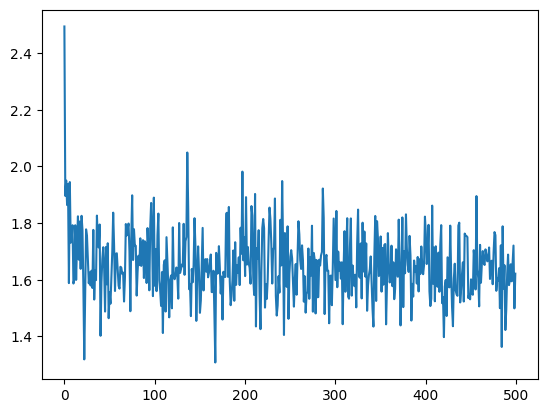

In [194]:
plt.plot(losses)

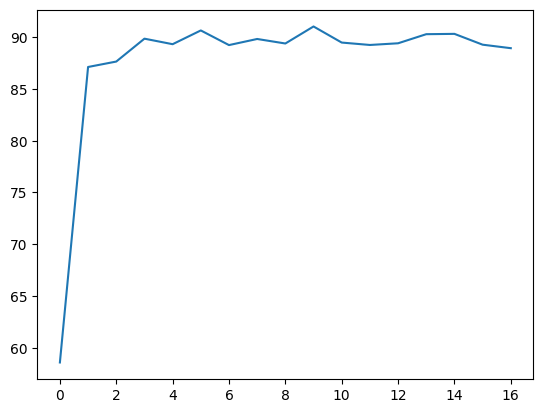

In [195]:
plt.plot(accuracies_per_epoch)

## Conditional Generation

In [169]:
def generate(model, angle, num_iter=100):
    x = gaussian.sample((1,))
    angle = torch.tensor([angle*torch.pi/180])
    for i in np.linspace(0, 1, num_iter, endpoint=False):
        t = torch.tensor([i], dtype=torch.float32)
        sin = torch.sin(angle)
        cos = torch.cos(angle)
        path = model(torch.cat([x, t[:, None], sin[:, None], cos[:, None]], dim=-1))
        x += (0.01 * path)
    return x.detach()

In [ ]:
flow = Flow(1024)
flow.load_state_dict(torch.load(model_path))
flow.eval()

def slider(angle):
    x = generate(flow, angle, num_iter=100)[0]
    X, y = get_moons_dataset()
    X_rotated = rotate(X, angle)
    plot_decision_boundary(x, X_rotated, y, title=f"{angle}° degrees")

from ipywidgets import interact
interact(slider, angle=(0, 360, 1))

interactive(children=(IntSlider(value=180, description='angle', max=360), Output()), _dom_classes=('widget-int…

<function __main__.slider(angle)>

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_300\2270370927.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Mean accuracy: 90.10773749999998


<Axes: ylabel='Density'>

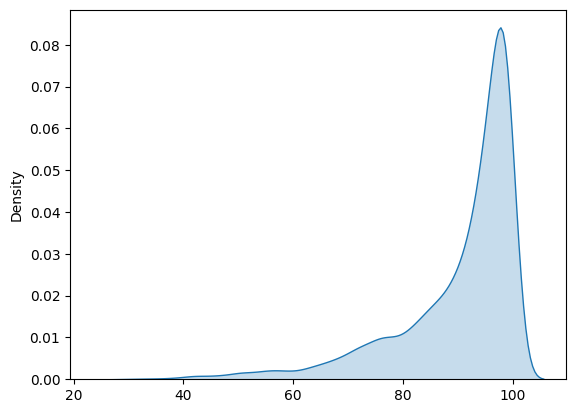

In [175]:
flow = Flow(1024)
flow.load_state_dict(torch.load(model_path))
flow.eval()
flow.to("cpu")

accuracies = []
angles = [0, 45, 90, 135, 180, 225, 270, 315]

with torch.no_grad():
    for angle in tqdm(angles):
        for i in range(1000):
            x = generate(flow, angle)[0]
            x = torch.tensor(x, dtype=torch.float32)

            X, y = get_moons_dataset()
            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            accuracy = get_accuracy(x, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))
sns.kdeplot(accuracies, fill=True)

In [198]:
flow = Flow(1024)
flow.load_state_dict(torch.load(model_path))
flow.eval()
flow.to("cpu")

accuracies = []
angles = [45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]

with torch.no_grad():
    for angle in tqdm(angles):
        for i in range(1000):
            x = generate(flow, angle)[0]
            x = torch.tensor(x, dtype=torch.float32)

            X, y = get_moons_dataset()
            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            accuracy = get_accuracy(x, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))
sns.kdeplot(accuracies, fill=True)

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_300\1981937671.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


KeyboardInterrupt: 

## Parameters distribution

In [29]:
flow = Flow(1024)
flow.load_state_dict(torch.load(model_path))
flow.eval()

angle = 0
accuracies = []

X, y = get_moons_dataset()
X = torch.tensor(X, dtype=torch.float32)

for i in range(1000):
    parameters = generate(flow, angle, num_iter=100)[0]
    accuracy = get_accuracy(parameters, X, y)
    accuracies.append(accuracy)
    
print("Mean accuracy:", np.mean(accuracies))

Mean accuracy: 93.38789999999999


(33, 1000)


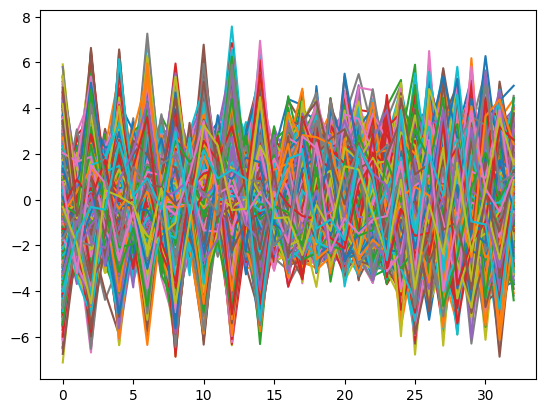

In [19]:
parameters = np.array(parameters)
print(parameters.T.shape)

plt.plot(parameters.T)
plt.show()

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchdyn
from torchdyn.datasets import generate_moons

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

In [60]:
def eight_normal_sample(n, dim, scale=1, var=1):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), math.sqrt(var) * torch.eye(dim)
    )
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
    ]
    centers = torch.tensor(centers) * scale
    noise = m.sample((n,))
    multi = torch.multinomial(torch.ones(8), n, replacement=True)
    data = []
    for i in range(n):
        data.append(centers[multi[i]] + noise[i])
    data = torch.stack(data)
    return data


def sample_moons(n):
    x0, _ = generate_moons(n, noise=0.2)
    return x0 * 3 - 1


def sample_8gaussians(n):
    return eight_normal_sample(n, 2, scale=5, var=0.1).float()

In [61]:
class MLP(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x):
        return self.net(x)

In [62]:
class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x, *args, **kwargs):
        return self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))


def plot_trajectories(traj):
    """Plot trajectories of some selected samples."""
    n = 2000
    plt.figure(figsize=(6, 6))
    plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
    plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
    plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
    plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
    plt.xticks([])
    plt.yticks([])
    plt.show()

5000: loss 0.164


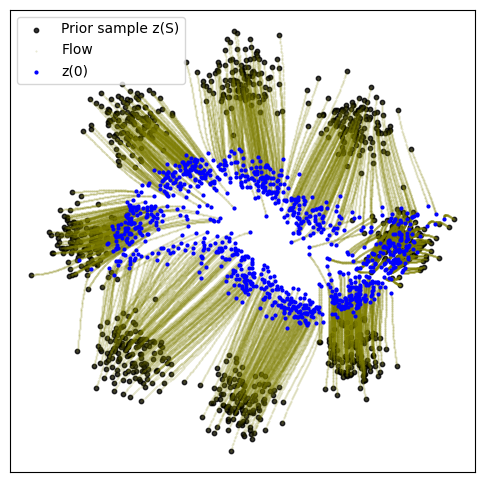

10000: loss 0.146


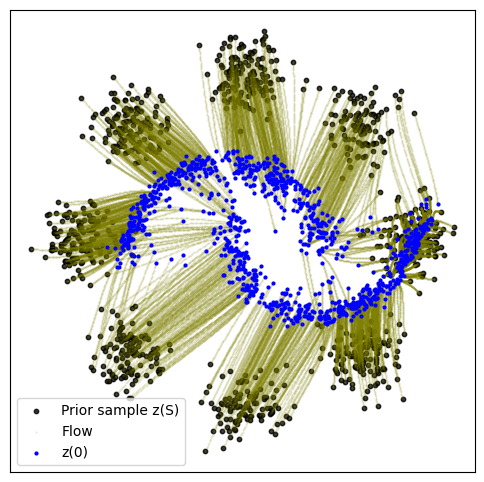

15000: loss 0.168


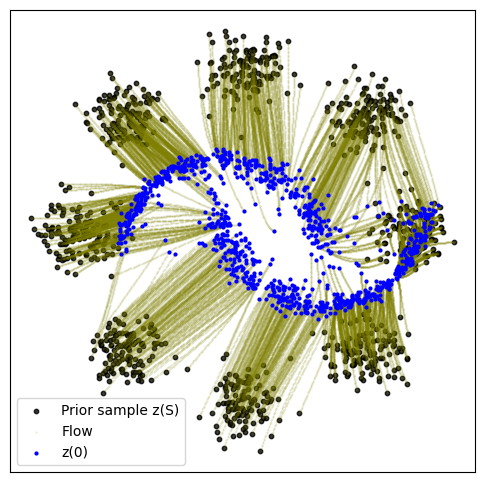

20000: loss 0.174


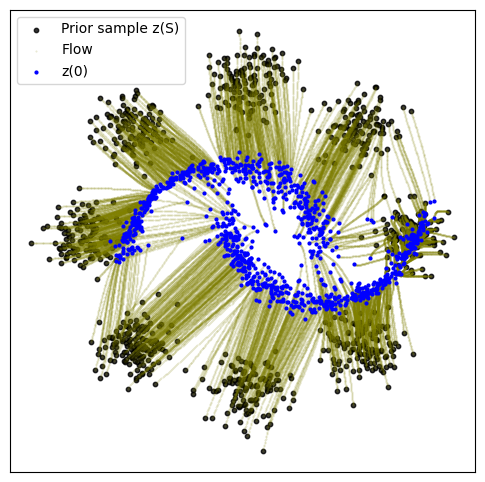

In [63]:

ot_sampler = OTPlanSampler(method="exact")
sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())

for k in range(20000):
    optimizer.zero_grad()

    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    # Draw samples from OT plan
    x0, x1 = ot_sampler.sample_plan(x0, x1)

    t = torch.rand(x0.shape[0]).type_as(x0)
    xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
    ut = compute_conditional_vector_field(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        print(f"{k+1}: loss {loss.item():0.3f}")
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())